In [53]:
dataset = {
    0: "./inpainting_dataset" ,
    1: "./negative_samples"
}

In [54]:
demonstrative = True
# Parameters for anomaly scoring visualization
model_checkpoint = "lmms-lab/llava-onevision-qwen2-0.5b-ov"  # or local path
size = "05b"  # or "7b"
images_dir = dataset[int(demonstrative)]
pattern = "*.*"  # glob pattern
max_side = 1024
show_n = 12  # number of images to visualize
subset_k = 100  # number of images to score and filter into negatives
sort_by_score = True  # if True, show top-N highest scores; else first N
images_dir


'./negative_samples'

In [ ]:

from glob import glob
from PIL import Image
import os, torch
from llava.model.builder import load_pretrained_model
from llava.mm_utils import process_images
from llava.model.anomaly_expert import AnomalyOV

# Load model
model_name = "llava_qwen"
_, model, image_processor, _ = load_pretrained_model(
    model_checkpoint,
    None,
    model_name,
    device_map="auto",
    cache_dir="./cache",
    torch_dtype="bfloat16",
    overwrite_config=None,
    attn_implementation="sdpa",
)
model.eval()
device = model.device

# Load anomaly encoder
if size != '7b':
    model.lm_head.weight = model.model.embed_tokens.weight
    anomaly_encoder_weight_path = './pretrained_expert_05b.pth'
else:
    anomaly_encoder_weight_path = './pretrained_expert_7b.pth'

anomaly_encoder = AnomalyOV()
anomaly_encoder.load_zero_shot_weights(path=anomaly_encoder_weight_path)
anomaly_encoder.freeze_layers()
anomaly_encoder.to(dtype=torch.float32, device='cpu')
anomaly_encoder.requires_grad_(False)
anomaly_encoder.eval()
#model.set_anomaly_encoder(anomaly_encoder)

# Collect images
image_paths = sorted([p for p in glob(os.path.join(images_dir, '**', pattern), recursive=True) if os.path.isfile(p)])
print(f"Found {len(image_paths)} images")
if not image_paths:
    raise SystemExit("No images found. Adjust images_dir/pattern.")

Loaded LLaVA model: lmms-lab/llava-onevision-qwen2-0.5b-ov


You are using a model of type llava to instantiate a model of type llava_qwen. This is not supported for all configurations of models and can yield errors.


Loading vision tower: google/siglip-so400m-patch14-384


/Users/francescobassignana/miniforge3/envs/deepl/lib/python3.10/site-packages/torch/nn/modules/module.py:2446: UserWarning: for vision_model.embeddings.patch_embedding.weight: copying from a non-meta parameter in the checkpoint to a meta parameter in the current model, which is a no-op. (Did you mean to pass `assign=True` to assign items in the state dictionary to their corresponding key in the module instead of copying them in place?)
  warnings.warn(
/Users/francescobassignana/miniforge3/envs/deepl/lib/python3.10/site-packages/torch/nn/modules/module.py:2446: UserWarning: for vision_model.embeddings.patch_embedding.bias: copying from a non-meta parameter in the checkpoint to a meta parameter in the current model, which is a no-op. (Did you mean to pass `assign=True` to assign items in the state dictionary to their corresponding key in the module instead of copying them in place?)
  warnings.warn(
/Users/francescobassignana/miniforge3/envs/deepl/lib/python3.10/site-packages/torch/nn/m

Model Class: LlavaQwenForCausalLM
Matched names: ['positive_embedding', 'negative_embedding', 'pooling_layer.0.weight', 'pooling_layer.0.bias', 'class_predictor.0.weight', 'class_predictor.0.bias', 'class_predictor.2.weight', 'class_predictor.2.bias', 'siglip_adaptors.0.weight', 'siglip_adaptors.0.bias', 'siglip_adaptors.1.weight', 'siglip_adaptors.1.bias', 'siglip_adaptors.2.weight', 'siglip_adaptors.2.bias', 'siglip_adaptors.3.weight', 'siglip_adaptors.3.bias', 'prompt_adaptors.0.weight', 'prompt_adaptors.0.bias', 'prompt_adaptors.1.weight', 'prompt_adaptors.1.bias', 'prompt_adaptors.2.weight', 'prompt_adaptors.2.bias', 'prompt_adaptors.3.weight', 'prompt_adaptors.3.bias', 'final_predictor.0.weight', 'final_predictor.0.bias', 'final_predictor.2.weight', 'final_predictor.2.bias', 'q_former.query_proj.weight', 'q_former.query_proj.bias', 'q_former.key_proj.weight', 'q_former.key_proj.bias']
Loaded number of keys: 32
Found 44 images


In [57]:
# Efficient sampling: reservoir sample subset_k image paths without loading all into memory
import fnmatch, random

def reservoir_sample_paths(root_dir, pattern, k):
    sample = []
    n = 0
    for dirpath, dirnames, filenames in os.walk(root_dir):
        for fname in filenames:
            if fnmatch.fnmatch(fname, pattern):
                full = os.path.join(dirpath, fname)
                if not os.path.isfile(full):
                    continue
                n += 1
                if len(sample) < k:
                    sample.append(full)
                else:
                    r = random.randint(1, n)
                    if r <= k:
                        sample[r-1] = full
    return sample, n

# If dataset is huge, only sample subset_k paths; otherwise fall back to previous list
if images_dir and subset_k and subset_k > 0:
    sampled_paths, total_seen = reservoir_sample_paths(images_dir, pattern, subset_k)
    print(f"Reservoir sampled {len(sampled_paths)} of ~{total_seen} candidates")
    image_paths_subset = sampled_paths
else:
    image_paths_subset = image_paths
print(f"Using {len(image_paths_subset)} images for scoring and negative export")


Reservoir sampled 44 of ~44 candidates
Using 44 images for scoring and negative export


In [58]:
# Compute anomaly scores for subset images only
import numpy as np
scores = []
for idx, img_path in enumerate(image_paths_subset, 1):
    try:
        img = Image.open(img_path).convert('RGB')
        if max(img.size) > max_side:
            if img.width > img.height:
                new_w = max_side
                new_h = int(max_side * img.height / img.width)
            else:
                new_h = max_side
                new_w = int(max_side * img.width / img.height)
            img = img.resize((new_w, new_h))
        image_tensor = process_images([img], image_processor, model.config)
        image_tensor = [_img.to(dtype=torch.bfloat16, device=device) for _img in image_tensor]
        _, _, final_preds = model.get_anomaly_fetures_from_images(image_tensor)
        score = float(final_preds.to(torch.float32).cpu().numpy().reshape(-1)[0])
        scores.append((img_path, score))
        if idx % 20 == 0:
            print(f"[{idx}] {img_path} -> {score:.6f}")
    except Exception as e:
        print(f"Error {img_path}: {e}")

print(f"Scored {len(scores)} subset images")
scores_array = np.array([[s[0], s[1]] for s in scores], dtype=object)


[20] ./negative_samples/000000164657.png -> 0.002747
[40] ./negative_samples/000000549171.png -> 0.057129
[40] ./negative_samples/000000549171.png -> 0.057129
Scored 44 subset images
Scored 44 subset images


Displaying 12 images


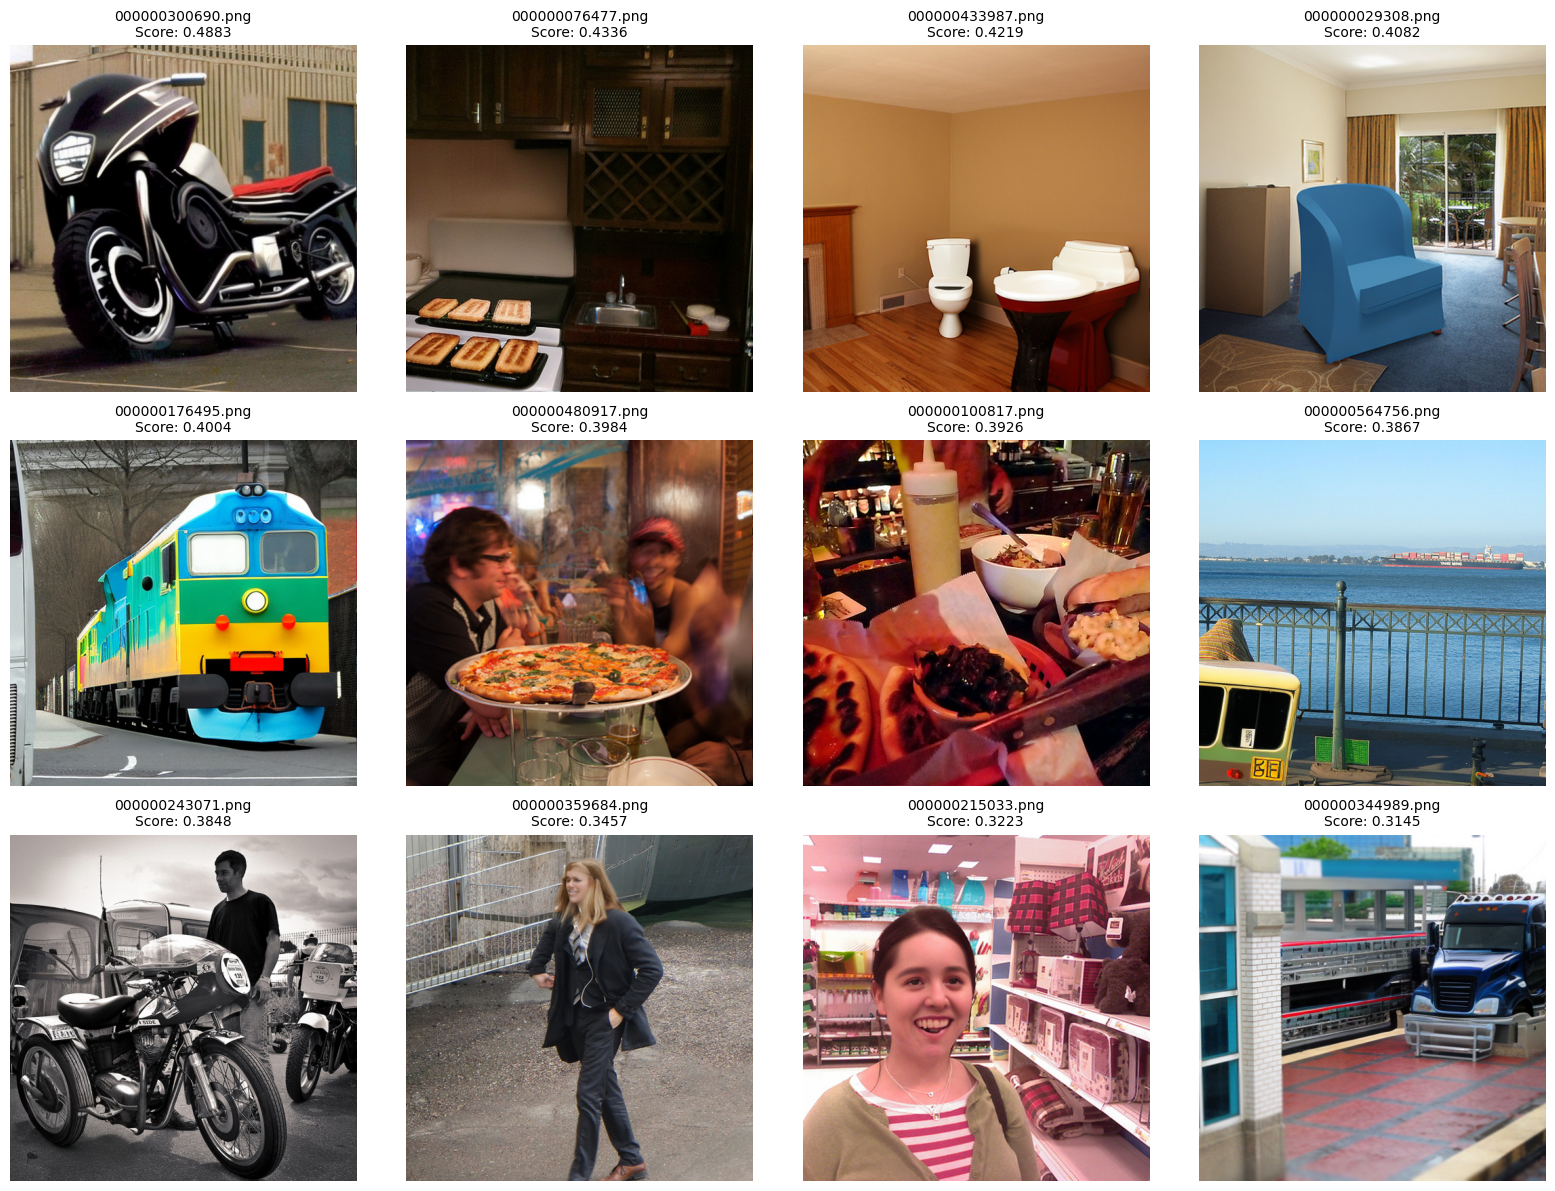

In [59]:
# Visualize first N images (optionally sorted by score) using matplotlib
import math, matplotlib.pyplot as plt

if sort_by_score:
    # Sort descending by anomaly score
    scores_sorted = sorted(scores, key=lambda x: x[1], reverse=True)
else:
    scores_sorted = scores

N = min(show_n, len(scores_sorted))
print(f"Displaying {N} images")

cols = 4
rows = math.ceil(N / cols)
fig, axes = plt.subplots(rows, cols, figsize=(cols*4, rows*4))
axes = axes.flatten()

for i in range(cols*rows):
    ax = axes[i]
    if i < N:
        img_path, sc = scores_sorted[i]
        img = Image.open(img_path).convert('RGB')
        # Resize for display (optional small max side)
        max_disp = 512
        if max(img.size) > max_disp:
            if img.width > img.height:
                new_w = max_disp
                new_h = int(max_disp * img.height / img.width)
            else:
                new_h = max_disp
                new_w = int(max_disp * img.width / img.height)
            img = img.resize((new_w, new_h))
        ax.imshow(img)
        ax.set_title(f"{os.path.basename(img_path)}\nScore: {sc:.4f}", fontsize=10)
        ax.axis('off')
    else:
        ax.axis('off')

plt.tight_layout()
plt.show()


# To creat negative dataset

In [52]:
# Export images with score < 0.5 to ./negative_samples
import shutil
from pathlib import Path

neg_dir = Path('./negative_samples')
neg_dir.mkdir(parents=True, exist_ok=True)

threshold = 0.5
negatives = [(p, s) for (p, s) in scores if s < threshold]
print(f"Found {len(negatives)} negatives with score < {threshold}")

for src, sc in negatives:
    try:
        dst = neg_dir / os.path.basename(src)
        shutil.copy2(src, dst)
    except Exception as e:
        print(f"Failed to copy {src} -> {dst}: {e}")

print(f"Copied {len(negatives)} files to {neg_dir}")


Found 44 negatives with score < 0.5
Copied 44 files to negative_samples
